# **Segement 1: Module Imports**

In [13]:
%pip install -q mauve-text
import os
import torch
import tiktoken
import math
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import numpy as np
import mauve
from tqdm import trange
from torch.utils.data import DataLoader
print("Imports and Installations Done")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.
Imports and Installations Done


# **Segement 2: Torch Device and Dataset Tokenizer Initialization**

In [14]:
tokenizer = tiktoken.get_encoding('gpt2')
vocab_size = tokenizer.n_vocab
vocab_size

50257

In [15]:
device = "cpu"
if torch.cuda.device_count() > 1:
    device = torch.device("cuda")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = "/kaggle/input/children-stories-text-corpus/cleaned_merged_fairy_tales_without_eos.txt"
text = open(data_dir, 'r').read()

data = torch.tensor(tokenizer.encode(text), dtype=torch.long).to(device)

# **Segement 3: Hyper Parameters Initialization**

In [16]:
train_batch_size = 16
eval_batch_size = 8
context_length = 512
train_split = 0.8
d_model = 512 
n_heads = 8
n_layers = 4
lr = 1e-3
epochs = 10000
eval_steps = 500
max_patience = 1500

# **Segement 4: DataLoader Defination**

In [ ]:
n_data = len(data)
train_data = data[:int(n_data * train_split)]
eval_data = data[int(n_data * train_split):]


class DataLoader:
    def __init__(self, tokens, batch_size, context_length) -> None:
        self.tokens = tokens
        self.batch_size = batch_size
        self.context_length = context_length

        self.current_position = 0

    def get_batch(self) -> torch.tensor:
        b, c = self.batch_size, self.context_length

        start_pos = self.current_position
        end_pos = self.current_position + b * c + 1

        add_data = -1
        if end_pos > len(self.tokens):
            add_data = end_pos - len(self.tokens)
            end_pos = len(self.tokens)

        d = self.tokens[start_pos:end_pos]
        if add_data != -1:
            d = torch.cat([d, self.tokens[:add_data]])

        x = (d[:-1]).view(b, c)  # inputs
        y = (d[1:]).view(b, c)  # targets

        self.current_position += b * c
        if self.current_position > len(self.tokens) - 1:
            self.current_position = 0
        return x, y

train_loader = DataLoader(train_data, train_batch_size, context_length)
eval_loader = DataLoader(eval_data, eval_batch_size, context_length)

In [18]:
xb, yb = train_loader.get_batch()
xb, yb = xb.to(device), yb.to(device)
print(xb.shape, yb.shape)

torch.Size([16, 512]) torch.Size([16, 512])


# **Segement 5: Model Defination**
Contains
- MultiHead Attention
- Positional Encoding
- Transfomer Block
- Our GPT Like custom Model
- Generate Function


In [19]:
# Multi-head Attention Layer
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x: torch.Tensor):
        B, T, D = x.shape

        Q = self.query(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        attn_scores = attn_scores.masked_fill(mask, float('-inf'))

        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(self.dropout(attn_weights), V)

        out = attn_output.transpose(1, 2).contiguous().view(B, T, D)
        return self.fc_out(out)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, context_length: int, d_model: int):
        super().__init__()
        pe = torch.zeros(context_length, d_model)
        position = torch.arange(0, context_length).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x: torch.Tensor):
        return x + self.pe[:, :x.size(1)]

# Transformer Block
class GPTBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.att = MultiHeadAttention(d_model, n_heads)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.dropout = nn.Dropout(0.2)

    def forward(self, x: torch.Tensor):
        x = x + self.att(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return self.dropout(x)

# GPT Model
class GPT(nn.Module):
    def __init__(self, vocab_size: int, context_length: int, d_model: int, n_heads: int, n_layers: int):
        super().__init__()
        self.context_length = context_length
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(context_length, d_model)
        self.blocks = nn.ModuleList([GPTBlock(d_model, n_heads) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

        # Weight tying
        self.head.weight = self.token_emb.weight

    def forward(self, x: torch.Tensor, targets: torch.Tensor = None):
        B, T = x.shape
        assert T <= self.context_length, "Sequence length exceeds context length"

        x = self.token_emb(x)
        x = self.pos_enc(x)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            logits = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, input_ids: torch.Tensor, max_new_tokens: int, temperature: float = 1.0, top_k: int = 0):
        self.eval()
        generated = input_ids

        for _ in range(max_new_tokens):
            input_trunc = generated[:, -self.context_length:]
            logits, _ = self(input_trunc)
            next_token_logits = logits[:, -1, :] / temperature
    
            if top_k > 0:
                top_k_vals, top_k_idx = torch.topk(next_token_logits, k=top_k, dim=-1)
                probs = F.softmax(top_k_vals, dim=-1)
                next_token = top_k_idx.gather(1, torch.multinomial(probs, num_samples=1))
            else:
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
    
            generated = torch.cat([generated, next_token], dim=1)
    
        return [tokenizer.decode(seq.tolist()) for seq in generated]

        
    def decode(ids):
        return [id2token.get(i, "<unk>") for i in ids if i not in {pad_token_id, eos_token_id}]

m = GPT(
    vocab_size=vocab_size,
    context_length=context_length,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers
)

if torch.cuda.device_count() > 1:
    m = nn.DataParallel(m)

m = m.to(device)

In [20]:
len(eval_data)

1020983

# **Segement 6: Model Description**

In [21]:
print(m)
print(f"Total Parameters: {round(sum(p.numel() for p in m.parameters() if p.requires_grad) / 1_000_000)}M")

DataParallel(
  (module): GPT(
    (token_emb): Embedding(50257, 512)
    (pos_enc): PositionalEncoding()
    (blocks): ModuleList(
      (0-3): 4 x GPTBlock(
        (att): MultiHeadAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (key): Linear(in_features=512, out_features=512, bias=True)
          (value): Linear(in_features=512, out_features=512, bias=True)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, e

**Test Generate Function**

In [22]:
with torch.no_grad():
    input = torch.tensor(tokenizer.encode("The Happy Prince "), dtype=torch.long, device=device).unsqueeze(0)
    print(m.module.generate(input, max_new_tokens=1000)[0])

The Happy Prince                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

# **Segement 7: Optimizer Used**

In [23]:
optim = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=3000, eta_min=lr*0.1)

# **Segement 8A: Training Loop**

In [24]:
train_loss = {}
mauve_scores = []
best_loss = float('inf')
patience_counter = 0
generated_references = []

for e in trange(epochs, desc="Training"):
    xb, yb = train_loader.get_batch()
    xb, yb = xb.to(device), yb.to(device).long()
    logits, loss = m(xb, yb)

    if loss is None:
        raise ValueError("Loss is None. Ensure targets are provided correctly.")
    if loss.dim() != 0:
        loss = loss.mean()

    optim.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(m.parameters(), max_norm=1)
    optim.step()
    scheduler.step()
    train_loss[e] = loss.item()

    if e % 500 == 0 or e == epochs - 1:
        m.eval()
        with torch.no_grad():
            xvb, yvb = eval_loader.get_batch()
            xvb, yvb = xvb.to(device), yvb.to(device).long()
            pred_logits, e_loss = m(xvb, yvb)

            if e_loss is not None and e_loss.dim() != 0:
                e_loss = e_loss.mean()

            generated_texts = []
            for input_seq in xvb:
                gen = m.module.generate(input_seq.unsqueeze(0), max_new_tokens=50, temperature=1.0, top_k=0)[0]
                generated_texts.append(gen)

            if generated_references:
                reference_texts = generated_references[-1]
            else:
                reference_texts = generated_texts

            try:
                mauve_result = mauve.compute_mauve(
                    p_text=generated_texts,
                    q_text=reference_texts,
                    device_id=0
                )
                mauve_score = mauve_result.mauve
            except Exception as ex:
                print(f"Error calculating MAUVE at epoch {e}: {str(ex)}")
                mauve_score = 0.0

            mauve_scores.append(mauve_score)
            print(f"Epoch: {e}\ttrain_loss: {loss:.4f}\teval_loss: {e_loss:.4f}\tMAUVE: {mauve_score}")

            if e_loss < best_loss:
                best_loss = e_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= max_patience:
                    print(f"Early stopping triggered at epoch {e}")
                    break

        m.train()
        generated_references.append(generated_texts)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:   0%|          | 1/10000 [00:11<31:43:26, 11.42s/it]

Epoch: 0	train_loss: 391.6683	eval_loss: 131.1447	MAUVE: 0.7500000000000007


Training:   5%|▌         | 500/10000 [04:27<1:21:57,  1.93it/s]

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:   5%|▌         | 501/10000 [04:40<11:18:31,  4.29s/it]

Epoch: 500	train_loss: 7.1764	eval_loss: 6.5588	MAUVE: 0.02526989310353911


Training:  10%|█         | 1000/10000 [08:57<1:16:35,  1.96it/s]

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  10%|█         | 1001/10000 [09:10<10:41:17,  4.28s/it]

Epoch: 1000	train_loss: 5.7182	eval_loss: 5.5540	MAUVE: 0.9094900649625759


Training:  15%|█▌        | 1500/10000 [13:26<1:12:07,  1.96it/s] 

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  15%|█▌        | 1501/10000 [13:39<10:07:55,  4.29s/it]

Epoch: 1500	train_loss: 5.7215	eval_loss: 5.5640	MAUVE: 0.7500000000000004


Training:  20%|██        | 2000/10000 [17:54<1:08:17,  1.95it/s] 

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  20%|██        | 2001/10000 [18:07<9:29:50,  4.27s/it]

Epoch: 2000	train_loss: 5.3752	eval_loss: 5.3142	MAUVE: 0.9896653056884555


Training:  25%|██▌       | 2500/10000 [22:23<1:04:24,  1.94it/s]

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  25%|██▌       | 2501/10000 [22:37<8:57:40,  4.30s/it]

Epoch: 2500	train_loss: 4.8644	eval_loss: 5.2708	MAUVE: 0.9896653056884555


Training:  30%|███       | 3000/10000 [26:52<58:58,  1.98it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  30%|███       | 3001/10000 [27:05<8:09:14,  4.19s/it]

Epoch: 3000	train_loss: 4.7607	eval_loss: 5.1916	MAUVE: 0.75


Training:  35%|███▌      | 3500/10000 [31:21<55:58,  1.94it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  35%|███▌      | 3501/10000 [31:34<7:45:57,  4.30s/it]

Epoch: 3500	train_loss: 4.8544	eval_loss: 4.8867	MAUVE: 0.9896653056884555


Training:  40%|████      | 4000/10000 [35:49<50:56,  1.96it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  40%|████      | 4001/10000 [36:02<7:06:12,  4.26s/it]

Epoch: 4000	train_loss: 4.5934	eval_loss: 4.8732	MAUVE: 0.7500000000000004


Training:  45%|████▌     | 4500/10000 [40:19<47:14,  1.94it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  45%|████▌     | 4501/10000 [40:32<6:34:54,  4.31s/it]

Epoch: 4500	train_loss: 4.4614	eval_loss: 4.9356	MAUVE: 0.9947940673668629


Training:  50%|█████     | 5000/10000 [44:47<42:58,  1.94it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  50%|█████     | 5001/10000 [45:01<5:59:36,  4.32s/it]

Epoch: 5000	train_loss: 4.7803	eval_loss: 5.1543	MAUVE: 0.7500000000000004


Training:  55%|█████▌    | 5500/10000 [49:17<38:41,  1.94it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  55%|█████▌    | 5501/10000 [49:30<5:24:12,  4.32s/it]

Epoch: 5500	train_loss: 4.3638	eval_loss: 4.7141	MAUVE: 0.7500000000000004


Training:  60%|██████    | 6000/10000 [53:46<34:12,  1.95it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  60%|██████    | 6001/10000 [53:59<4:45:18,  4.28s/it]

Epoch: 6000	train_loss: 4.0116	eval_loss: 4.2016	MAUVE: 0.941004347338902


Training:  65%|██████▌   | 6500/10000 [58:15<29:57,  1.95it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  65%|██████▌   | 6501/10000 [58:28<4:09:38,  4.28s/it]

Epoch: 6500	train_loss: 4.2781	eval_loss: 4.2354	MAUVE: 0.9094900649625759


Training:  70%|███████   | 7000/10000 [1:02:45<25:29,  1.96it/s]

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  70%|███████   | 7001/10000 [1:02:58<3:34:34,  4.29s/it]

Epoch: 7000	train_loss: 4.3801	eval_loss: 4.2806	MAUVE: 0.6620836461535138


Training:  75%|███████▌  | 7500/10000 [1:07:14<21:17,  1.96it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  75%|███████▌  | 7501/10000 [1:07:27<2:57:42,  4.27s/it]

Epoch: 7500	train_loss: 4.1055	eval_loss: 4.3534	MAUVE: 0.9947940673668628


Training:  80%|████████  | 8000/10000 [1:11:43<17:11,  1.94it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  80%|████████  | 8001/10000 [1:11:56<2:23:03,  4.29s/it]

Epoch: 8000	train_loss: 3.7867	eval_loss: 4.1981	MAUVE: 0.6620836461535138


Training:  85%|████████▌ | 8500/10000 [1:16:13<12:54,  1.94it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  85%|████████▌ | 8501/10000 [1:16:26<1:47:14,  4.29s/it]

Epoch: 8500	train_loss: 3.8030	eval_loss: 4.6140	MAUVE: 0.7500000000000004


Training:  90%|█████████ | 9000/10000 [1:20:42<08:36,  1.93it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  90%|█████████ | 9001/10000 [1:20:56<1:11:53,  4.32s/it]

Epoch: 9000	train_loss: 3.6018	eval_loss: 4.0943	MAUVE: 0.9896653056884555


Training:  95%|█████████▌| 9500/10000 [1:25:11<04:17,  1.94it/s]  

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training:  95%|█████████▌| 9501/10000 [1:25:24<35:25,  4.26s/it]

Epoch: 9500	train_loss: 3.8171	eval_loss: 4.1059	MAUVE: 0.6620836461535138


Training: 100%|█████████▉| 9999/10000 [1:29:40<00:00,  1.93it/s]

Featurizing p:   0%|          | 0/8 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/8 [00:00<?, ?it/s]

WARNING clustering 16 points to 2 centroids: please provide at least 78 training points
Training: 100%|██████████| 10000/10000 [1:29:54<00:00,  1.85it/s]

Epoch: 9999	train_loss: 3.8208	eval_loss: 3.8752	MAUVE: 0.9947940673668629


# **Segement 8B: Model Loader**

In [25]:
# # Comment Out Above Segemnt and uncommne below to load the model

# m.load_state_dict(torch.load("/kaggle/input/storygen/pytorch/v1/1/model.pth", map_location="cpu"))
# m.eval()

# **Segement 9: Text Generation**

In [32]:
with torch.no_grad():
    input = torch.tensor(tokenizer.encode("The Happy Prince "), dtype=torch.long, device=device).unsqueeze(0)
    p_generated_text = m.module.generate(input, max_new_tokens=200)[0]
    q_generated_text = m.module.generate(input, max_new_tokens=200)[0]
    print(p_generated_text)

    mauve_result = mauve.compute_mauve(
        p_text=[p_generated_text],
        q_text=[q_generated_text],
        device_id=0)
    print(f"MAUVE score: {mauve_result.mauve*100}")

The Happy Prince 
 made the Giant over the Fairy of food he met "ti-t proclaiming the matter, the Lord the Princess. But while she listened to her "Tut' him drawing-worn wretch."
The Floating stayed in memory of her palace; but the Princess had not been married, and his repeated constraint, "Sit down nearer to her horse that I can endure my palace, just when I come to him!"
It was said, there was no sooner set the you know what the King had said the Princess.
"I will crawl out," said the Princess. "O drummer!" she asked.
The Prince didn't care if her husband had the effect of the same voices it was as soon as she saw the Princess to seek you for you all the kingdom?"
"I shall, right. You can be frightened," said Ivan, who was very angry.
"Reggie," answered the Princess, "there is no sign to stomach you."
"Do you


Featurizing p:   0%|          | 0/1 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/1 [00:00<?, ?it/s]

MAUVE score: 0.40720962619612555


WARNING clustering 2 points to 2 centroids: please provide at least 78 training points


**Variations over 'temperature' and 'top_k sampling' values**

In [33]:
with torch.no_grad():
    input = torch.tensor(tokenizer.encode("The Happy Prince "), dtype=torch.long, device=device).unsqueeze(0)

    variations = [
        {"temperature": 0.7, "top_k": 50},
        {"temperature": 1.0, "top_k": 40},
        {"temperature": 1.2, "top_k": 30},
    ]
    
    for i, params in enumerate(variations, 1):

        p_generated_text = m.module.generate(input, max_new_tokens=200, temperature=params["temperature"], top_k=params["top_k"])[0]
        print(f"\n--- Variation {i} (temp={params['temperature']}, top_k={params['top_k']}) ---\n")
        print(f"Text: {p_generated_text}")



--- Variation 1 (temp=0.7, top_k=50) ---

Text: The Happy Prince 
A LITTLE CER 
A ROUSE, in the middle of the morning, who had seen him to see him the Princess, said, "My son of the Princess."
The Prince sat down, and he gave her a knife. He knew her to be a little Princess, and her father had never seen her.
When the Prince had finished her, and the King thought she had a great pleasure to go to the Princess, and she thought to herself, "Why did you see that you were my husband?"
"I am sorry you were not to be married?" she asked, and he was very glad to make her get into her hand.
Then the King took her back to the palace, and the Prince said to the Princess that she had had no son of the King, but she had been so fond of the Princess, and soon she was afraid to go out to see her, and the Prince had to go home again in the Princess.

--- Variation 2 (temp=1.0, top_k=40) ---

Text: The Happy Prince 
A ROUB-man was very much too long.
After having been so many years or so, and now tha

# **Segement 10: Loss Visualization**

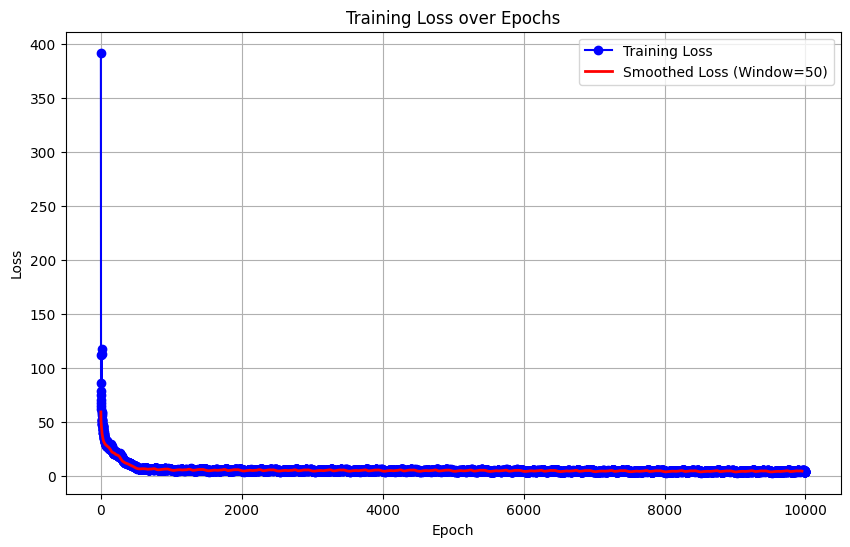

In [34]:
epochs = list(train_loss.keys())
losses = list(train_loss.values())

smooth_window = 50

smoothed_losses = np.convolve(losses, np.ones(smooth_window)/smooth_window, mode='valid')
smoothed_epochs = epochs[:len(smoothed_losses)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(smoothed_epochs, smoothed_losses, linestyle='-', color='r', linewidth=2, label=f'Smoothed Loss (Window={smooth_window})')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# **Outlier Trimmed** Plotting

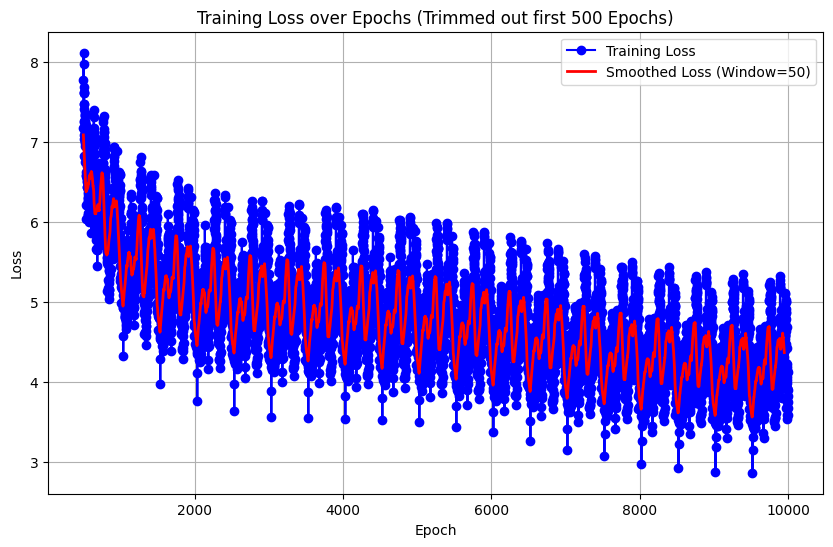

In [40]:
epochs = list(train_loss.keys())
losses = list(train_loss.values())
trimmed_losses = losses[500:]
trimmed_epochs = epochs[500:]
smooth_window = 50

smoothed_losses = np.convolve(trimmed_losses, np.ones(smooth_window)/smooth_window, mode='valid')
smoothed_epochs = trimmed_epochs[:len(smoothed_losses)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(trimmed_epochs, trimmed_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(smoothed_epochs, smoothed_losses, linestyle='-', color='r', linewidth=2, label=f'Smoothed Loss (Window={smooth_window})')
plt.title('Training Loss over Epochs (Trimmed out first 500 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

**Saving the model to avoid training**

In [35]:
torch.save(m.state_dict(), "/kaggle/working/model.pth")